# # London Crime MLP Classifier
# Predicting **Crime type** using TensorFlow/Keras Multi-Layer Perceptron Neural Network

In [1]:
# Libraries

# %%
import psutil
import matplotlib.pyplot as plt
from collections import deque
import time
import os
import io
import requests
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, recall_score, confusion_matrix, roc_auc_score, accuracy_score
from sklearn import metrics
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, Conv1D, GlobalMaxPooling1D, Flatten, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import mixed_precision
from tensorflow.keras.regularizers import l2
import seaborn as sns

2025-12-15 01:21:02.577398: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-15 01:21:02.652750: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-15 01:21:04.183710: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Class Declaration

In [2]:
def plot_training_history(history, save_path="Model"):
    os.makedirs(save_path, exist_ok=True)

    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("Model accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Model loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")

    plt.tight_layout()
    plt.savefig(os.path.join(save_path, "training_history.png"))
    plt.close()
    print(f"[✓] Saved training history plot to {save_path}/training_history.png")

def save_model_checkpoint(model, epoch_label, save_path="Model"):
    os.makedirs(save_path, exist_ok=True)

    # Save full model (architecture + weights)
    model.save(os.path.join(save_path, f"model_epoch_{epoch_label}.h5"))

    # Save weights (NEW required naming)
    model.save_weights(
        os.path.join(save_path, f"weights_epoch_{epoch_label}.weights.h5")
    )

    print(f"[✓] Saved model at epoch {epoch_label}")




# ## GPU Acceleration Pre-Training Hardware Verification

In [3]:
# GPU Configuration (safe defaults)
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# --- Toggles (use these if your GPU/driver supports them) ---
USE_MIXED_PRECISION = False   # set True for faster training on supported GPUs
USE_XLA = False               # set True to enable XLA (jit_compile) - can cause "illegal access" on some setups

# Enable memory growth to prevent TensorFlow from allocating all GPU memory at once
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU(s) configured: {[gpu.name for gpu in gpus]}")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found, running on CPU")

# Mixed precision (optional)
if USE_MIXED_PRECISION:
    mixed_precision.set_global_policy('mixed_float16')
    print("Mixed precision enabled: mixed_float16")
else:
    mixed_precision.set_global_policy('float32')
    print("Mixed precision disabled: float32")


TensorFlow version: 2.20.0
Num GPUs Available:  1
GPU(s) configured: ['/physical_device:GPU:0']
Mixed precision disabled: float32


# ## Load Dataset

In [4]:
# Step 1: Memory-Efficient Data Preprocessing (Chunked CSV → HDF5)
input_csv = "Dataset/mergedCRDataset.csv"
preprocessed_hdf5_file = "Dataset/Preprocessed/london_crime_data.h5"
os.makedirs(os.path.dirname(preprocessed_hdf5_file), exist_ok=True)

chunksize = 1_000_000
chunk_idx = 0

numeric_cols = ['Longitude', 'Latitude']
categorical_cols = ['Reported by', 'Falls within']
target_col = 'Crime type'
group_col = 'LSOA name'

Class Defnition and Instantiation

In [5]:
class LiveRAMPlot(tf.keras.callbacks.Callback):
    def __init__(self, max_points=100):
        self.ram = deque(maxlen=max_points)
        self.t = deque(maxlen=max_points)
        self.start = time.time()

        plt.ion()
        self.fig, self.ax = plt.subplots(figsize=(8, 4))
        self.line, = self.ax.plot([], [], linewidth=2)
        self.ax.set_title("Live RAM Usage")
        self.ax.set_ylabel("GB Used")
        self.ax.set_xlabel("Time (s)")

    def on_epoch_end(self, epoch, logs=None):
        mem = psutil.virtual_memory()
        self.ram.append(mem.used / (1024**3))
        self.t.append(time.time() - self.start)

        self.line.set_data(self.t, self.ram)
        self.ax.relim()
        self.ax.autoscale_view()
        plt.pause(0.1)


class LondonCrimePreprocessor:
    
    ## - Drops leakage / non-informative columns
    ## - Drops rows with missing target
    ## - Imputes numeric NaNs (per-chunk median)
    ## - Encodes categorical + target using persistent dictionaries (no sklearn needed)
    ## - Writes incrementally to HDF5 to avoid holding the full dataset in RAM
    ## - Saves encoder mappings for future deployment/inference

    def __init__(
        self,
        input_csv: str,
        hdf5_path: str,
        encoders_path: str,
        numeric_cols: list,
        categorical_cols: list,
        target_col: str,
        drop_cols: list,
        sep: str = "\t",
        chunksize: int = 1_000_000,
        on_bad_lines: str = "skip",
        engine: str = "python",
        verbose: bool = True,
    ):
        self.input_csv = input_csv
        self.hdf5_path = hdf5_path
        self.encoders_path = encoders_path
        self.numeric_cols = numeric_cols
        self.categorical_cols = categorical_cols
        self.target_col = target_col
        self.drop_cols = drop_cols
        self.sep = sep
        self.chunksize = chunksize
        self.on_bad_lines = on_bad_lines
        self.engine = engine
        self.verbose = verbose

        # dict encoders: {col: {category_string: int_id}}
        self.cat_maps = {c: {} for c in self.categorical_cols}
        self.target_map = {}  # {target_string: int_id}

    def _encode_series(self, s: pd.Series, mapping: dict) -> np.ndarray:
        # Ensure string + handle missing
        s = s.astype("string").fillna("Unknown")
        out = np.empty(len(s), dtype=np.int32)

        # Fast path: use map then fill for unseen
        mapped = s.map(mapping)
        unseen_mask = mapped.isna()

        if unseen_mask.any():
            unseen_vals = s[unseen_mask].unique().tolist()
            start = len(mapping)
            for i, v in enumerate(unseen_vals):
                mapping[str(v)] = start + i
            mapped = s.map(mapping)

        out[:] = mapped.astype(np.int32).to_numpy()
        return out

    def preprocess(self):
        os.makedirs(os.path.dirname(self.hdf5_path), exist_ok=True)
        os.makedirs(os.path.dirname(self.encoders_path), exist_ok=True)

        n_features = len(self.numeric_cols) + len(self.categorical_cols)

        if os.path.exists(self.hdf5_path):
            if self.verbose:
                print(f"✓ Preprocessed data already exists at {self.hdf5_path}")
                print("Skipping preprocessing... Loading from file.")
            return

        if self.verbose:
            print(f"Preprocessing dataset and saving to {self.hdf5_path}...")

        with h5py.File(self.hdf5_path, "w") as h5:
            X_ds = h5.create_dataset(
                "X",
                shape=(0, n_features),
                maxshape=(None, n_features),
                dtype="float32",
                chunks=True,
            )
            y_ds = h5.create_dataset(
                "y",
                shape=(0,),
                maxshape=(None,),
                dtype="int32",
                chunks=True,
            )

            total_rows = 0
            chunk_idx = 0

            for chunk in pd.read_csv(
                self.input_csv,
                sep=self.sep,
                engine=self.engine,
                on_bad_lines=self.on_bad_lines,
                chunksize=self.chunksize,
            ):
                chunk_idx += 1
                chunk.columns = chunk.columns.str.strip()

                # Drop duplicates
                chunk.drop_duplicates(inplace=True)

                # Drop leakage / noise cols (if present)
                chunk.drop(columns=self.drop_cols, inplace=True, errors="ignore")

                # Drop rows missing the target
                if self.target_col not in chunk.columns:
                    if self.verbose:
                        print(f"[!] Chunk {chunk_idx}: target column '{self.target_col}' not found. Skipping chunk.")
                    continue
                chunk = chunk.dropna(subset=[self.target_col])

                # Keep only required columns
                keep_cols = [c for c in (self.numeric_cols + self.categorical_cols + [self.target_col]) if c in chunk.columns]
                chunk = chunk[keep_cols].copy()

                # Numeric imputation (per-chunk median)
                for col in self.numeric_cols:
                    if col in chunk.columns:
                        med = chunk[col].median()
                        chunk[col] = chunk[col].fillna(med)

                # Fill categorical missing with Unknown
                for col in self.categorical_cols:
                    if col in chunk.columns:
                        chunk[col] = chunk[col].astype("string").fillna("Unknown")

                # --- Monitoring summary ---
                if self.verbose:
                    summary = pd.DataFrame({
                        "missing": chunk.isna().sum(),
                        "non_missing": chunk.notna().sum(),
                        "total": len(chunk)
                    })
                    print(f"\nChunk {chunk_idx} summary:")
                    print(summary)

                # Encode features
                X_parts = []

                # numeric
                for col in self.numeric_cols:
                    if col in chunk.columns:
                        X_parts.append(chunk[col].to_numpy(dtype=np.float32))
                    else:
                        # if missing in file, fill with zeros
                        X_parts.append(np.zeros(len(chunk), dtype=np.float32))

                # categorical
                for col in self.categorical_cols:
                    if col in chunk.columns:
                        enc = self._encode_series(chunk[col], self.cat_maps[col]).astype(np.float32)
                        X_parts.append(enc)
                    else:
                        X_parts.append(np.zeros(len(chunk), dtype=np.float32))

                X_chunk = np.stack(X_parts, axis=1).astype(np.float32)

                # Encode target
                y_enc = self._encode_series(chunk[self.target_col], self.target_map)

                # Append to HDF5 (resize)
                new_total = total_rows + len(chunk)
                X_ds.resize((new_total, n_features))
                y_ds.resize((new_total,))

                X_ds[total_rows:new_total, :] = X_chunk
                y_ds[total_rows:new_total] = y_enc

                total_rows = new_total

                if self.verbose:
                    print(f"Chunk {chunk_idx} target value counts (top 10):")
                    print(chunk[self.target_col].value_counts().head(10))
                    print(f"[✓] Appended {len(chunk):,} rows. Total so far: {total_rows:,}")

            if self.verbose:
                print(f"\nTotal number of samples saved: {total_rows:,}")

        # Save encoders for deployment
        encoders = {
            "categorical_maps": self.cat_maps,
            "target_map": self.target_map,
            "numeric_cols": self.numeric_cols,
            "categorical_cols": self.categorical_cols,
            "target_col": self.target_col,
            "drop_cols": self.drop_cols,
        }
        with open(self.encoders_path, "wb") as f:
            pickle.dump(encoders, f)

        if self.verbose:
            print(f"✓ Preprocessing complete! Data saved to HDF5.")
            print(f"✓ Encoder mappings saved to: {self.encoders_path}")


# ## Data Preprocessing

In [6]:
# Step 1: Memory-Efficient Data Preprocessing (Chunked CSV → HDF5)
# Only preprocess if file doesn't already exist

drop_columns = [
    "Crime ID"
]

encoders_path = os.path.join(os.path.dirname(preprocessed_hdf5_file), "encoders.pkl")

preprocessor = LondonCrimePreprocessor(
    input_csv=input_csv,
    hdf5_path=preprocessed_hdf5_file,
    encoders_path=encoders_path,
    numeric_cols=numeric_cols,
    categorical_cols=categorical_cols,
    target_col=target_col,
    drop_cols=drop_columns,
    sep="\t",
    chunksize=chunksize,
    verbose=True,
)

preprocessor.preprocess()


Preprocessing dataset and saving to Dataset/Preprocessed/london_crime_data.h5...

Chunk 1 summary:
              missing  non_missing   total
Longitude           0       648975  648975
Latitude            0       648975  648975
Reported by         0       648975  648975
Falls within        0       648975  648975
Crime type          0       648975  648975
Chunk 1 target value counts (top 10):
Crime type
Violence and sexual offences    239049
Anti-social behaviour            71511
Public order                     58456
Criminal damage and arson        55822
Other theft                      52460
Vehicle crime                    43717
Shoplifting                      35943
Burglary                         28843
Drugs                            18164
Other crime                      12164
Name: count, dtype: int64
[✓] Appended 648,975 rows. Total so far: 648,975

Chunk 2 summary:
              missing  non_missing   total
Longitude           0       595274  595274
Latitude            0    

# ## Train/Test Split

In [7]:
# Step 2: Load Preprocessed Data, Train/Test Split, Scaling (NO leakage), One-Hot target
with h5py.File(preprocessed_hdf5_file, 'r') as hdf5_file:
    X = hdf5_file['X'][:]   # shape: (N, n_features)
    y = hdf5_file['y'][:]   # shape: (N,)

print("Loaded X shape:", X.shape)
print("Loaded y shape:", y.shape)

# Train-Test Split (stratify by integer labels)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")

# Scale numeric features ONLY (fit on train, transform test)
scaler = StandardScaler()

n_num = len(numeric_cols)
X_train[:, :n_num] = scaler.fit_transform(X_train[:, :n_num])
X_test[:, :n_num] = scaler.transform(X_test[:, :n_num])

# Number of classes inferred from training split
num_classes = int(np.max(y_train)) + 1
print("num_classes:", num_classes)

# One-hot encode targets
y_train_oh = to_categorical(y_train, num_classes=num_classes)
y_test_oh = to_categorical(y_test, num_classes=num_classes)

print("y_train_oh shape:", y_train_oh.shape)
print("y_test_oh shape:", y_test_oh.shape)


Loaded X shape: (17153885, 4)
Loaded y shape: (17153885,)
Training samples: 13723108, Testing samples: 3430777
num_classes: 14
y_train_oh shape: (13723108, 14)
y_test_oh shape: (3430777, 14)


In [8]:
# Class weights (handle imbalance) - use integer labels (NO argmax needed)

# Get actual unique classes present in training data
classes = np.unique(y_train.astype(np.int32))

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train.astype(np.int32)
)

class_weight_dict = {int(cls): float(w) for cls, w in zip(classes, class_weights)}

print("Class weights:")
for k, v in class_weight_dict.items():
    print(f"Class {k}: {v:.3f}")


Class weights:
Class 0: 0.622
Class 1: 0.926
Class 2: 0.196
Class 3: 3.378
Class 4: 0.938
Class 5: 5.464
Class 6: 1.183
Class 7: 0.889
Class 8: 6.945
Class 9: 1.701
Class 10: 0.908
Class 11: 2.247
Class 12: 3.417
Class 13: 7.484


# ## Model Definition

In [9]:
# MLP Model Definition (kept from Model Creation version; output fixed to num_classes)

model = Sequential()

model.add(Input(shape=X_train.shape[1:]))

# Add L2 regularization to first dense layer
model.add(Dense(
    128,
    activation='relu',
    kernel_regularizer=l2(0.0005)   # <<< L2 penalty
))

model.add(Dense(
    64,
    activation='relu',
    kernel_regularizer=l2(0.0001)   # <<< L2 penalty
))

# Output layer
model.add(Dense(
    num_classes,
    activation='softmax'
))

optimizer = Adam(learning_rate=0.00001)

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=[
        'accuracy',
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.Precision(name='precision')
    ],
    jit_compile=USE_XLA  # <<< XLA compilation (optional)
)

model.summary()

save_path = 'Model'
os.makedirs(save_path, exist_ok=True)


I0000 00:00:1765762061.708739  154810 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21087 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:04.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 14)             │           910 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,806 (38.30 KB)

 Trainable params: 9,806 (38.30 KB)

 Non-trainable params: 0 (0.00 B)

# ## Training


Training to reach 10 total epochs (10 new epochs)...
Epoch 1/10
3351/3351 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0653 - loss: 3.7375 - precision: 0.0807 - recall: 0.0103

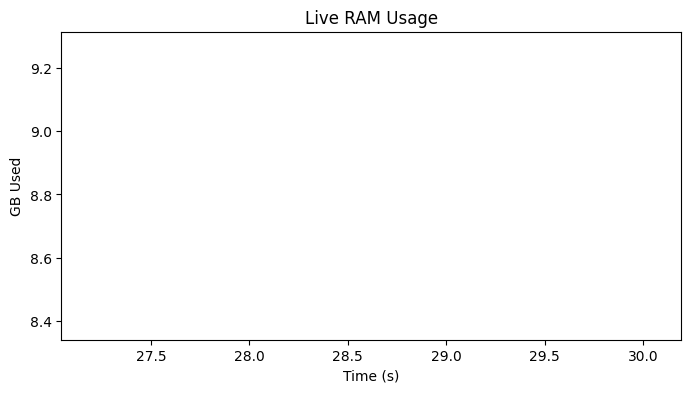

3351/3351 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.0572 - loss: 3.0449 - precision: 0.0808 - recall: 0.0025 - val_accuracy: 0.0436 - val_loss: 2.6434 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 2/10
3351/3351 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.0427 - loss: 2.6230 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0466 - val_loss: 2.6262 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 3/10
3351/3351 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.0481 - loss: 2.6109 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0580 - val_loss: 2.6161 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 4/10
3351/3351 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.0554 - loss: 2.6045 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0520 - val_loss: 2.6210 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.

[✓] Saved model at epoch 10

Training to reach 25 total epochs (15 new epochs)...
Epoch 1/15
3351/3351 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.0621 - loss: 2.5842 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0644 - val_loss: 2.6015 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 2/15
3351/3351 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.0636 - loss: 2.5821 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0621 - val_loss: 2.6059 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 3/15
3351/3351 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.0649 - loss: 2.5802 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0663 - val_loss: 2.6053 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 4/15
3351/3351 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.0664 - loss: 2.5785 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accurac

[✓] Saved model at epoch 25


In [10]:
# Training (staged epochs) - using numpy arrays directly

epoch_intervals = [10, 25]
previous_epochs = 0
stage_histories = {}

ram_plot_cb = LiveRAMPlot()

for target_epochs in epoch_intervals:
    epochs_to_run = target_epochs - previous_epochs

    print(
        f"\nTraining to reach {target_epochs} total epochs "
        f"({epochs_to_run} new epochs)..."
    )

    history = model.fit(
        X_train, y_train_oh,
        validation_data=(X_test, y_test_oh),
        epochs=epochs_to_run,
        batch_size=4096,   # adjust for your RAM/GPU (2048/4096 are common for tabular)
        verbose=1,
        class_weight=class_weight_dict,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=1e-7
            ),
            ram_plot_cb
        ]
    )

    stage_histories[f"up_to_{target_epochs}_epochs"] = history.history

    save_model_checkpoint(model, target_epochs, save_path="Model")

    previous_epochs = target_epochs


In [11]:
# --- Save staged training history ---
history_file = os.path.join(save_path, 'staged_training_history.pkl')
with open(history_file, 'wb') as f:
    pickle.dump(stage_histories, f)

# --- Save the full model and weights ---
model_file = os.path.join(save_path, 'my_model.h5')
weights_file = os.path.join(save_path, 'my_model_weights.h5')

model.save(model_file)
model.save_weights(weights_file)

print(f"Staged training history saved to {history_file}")
print(f"Model saved to {model_file}")
print(f"Weights saved to {weights_file}")


ValueError: The filename must end in `.weights.h5`. Received: filepath=Model/my_model_weights.h5

Evaluation Defnition

In [ ]:
# --- Generate predictions for evaluation ---
y_probs = model.predict(X_test)                    # Probabilities
y_pred_classes = np.argmax(y_probs, axis=1)        # Predicted labels (ints)
y_true_classes = y_test.astype(int)                # True labels (ints)

# For compatibility with later code:
all_true = y_true_classes
all_preds = y_pred_classes
all_probs = y_probs


Evaluation

In [14]:
# Track loss and accuracy for visualization
loss_across_epochs = history.history['loss']
val_accuracy_across_epochs = history.history['val_accuracy']

In [ ]:
# Visualization (example for Training Loss vs Validation Accuracy)
fig, ax = plt.subplots(figsize=(8, 6))
epochs_range = range(1, len(loss_across_epochs) + 1)
ax_twin = ax.twinx()
line1 = ax.plot(epochs_range, loss_across_epochs, 'b-o', label='Training Loss', linewidth=2)
line2 = ax_twin.plot(epochs_range, val_accuracy_across_epochs, 'g-s', label='Validation Accuracy', linewidth=2)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12, color='b')
ax_twin.set_ylabel('Accuracy', fontsize=12, color='g')
ax.tick_params(axis='y', labelcolor='b')
ax_twin.tick_params(axis='y', labelcolor='g')
ax.grid(True, alpha=0.3)
ax.set_title('Training Loss vs Validation Accuracy', fontsize=14, fontweight='bold')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc='upper left', fontsize=10)

In [ ]:
plt.tight_layout()
plt.savefig('model_training_performance.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
#make predictions (will give a probability distribution)
pred_hot = model.predict(X_test)
#now pick the most likely outcome
pred = np.argmax(pred_hot,axis=1)
y_compare = y_test.astype(int) 
#calculate accuracy
score = metrics.accuracy_score(y_compare, pred)

print("Accuracy score: {}".format(score))

print(pred_hot[:5])
print(pred)

# ## Evaluation

In [ ]:

# num_classes already computed earlier
# num_classes = ...

# --- Step 2: Classification report ---
print("=" * 80)
print("COMPREHENSIVE MODEL EVALUATION METRICS")
print("=" * 80)
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes))

In [ ]:
# --- Step 3: F1 Scores ---
macro_f1 = f1_score(y_true_classes, y_pred_classes, average='macro', zero_division=0)
weighted_f1 = f1_score(y_true_classes, y_pred_classes, average='weighted', zero_division=0)
print(f"\n1. F1 SCORES:")
print(f"   Macro F1 (treats all classes equally): {macro_f1:.4f}")
print(f"   Weighted F1 (accounts for class imbalance): {weighted_f1:.4f}")

In [ ]:
# --- Step 4: Recall Scores ---
macro_recall = recall_score(y_true_classes, y_pred_classes, average='macro', zero_division=0)
weighted_recall = recall_score(y_true_classes, y_pred_classes, average='weighted', zero_division=0)
per_class_recall = recall_score(y_true_classes, y_pred_classes, average=None, zero_division=0)
print(f"\n2. RECALL SCORES (Detection Rate):")
print(f"   Macro Recall: {macro_recall:.4f}")
print(f"   Weighted Recall: {weighted_recall:.4f}")
print(f"   Per-class Recall:")
for i, recall in enumerate(per_class_recall):
    print(f"      Class {i}: {recall:.4f}")

In [ ]:
# --- Step 5: Confusion Matrix ---
cm = confusion_matrix(y_true_classes, y_pred_classes)
print(f"\n3. Confusion Matrix:")
print(cm)

In [ ]:
# --- Step 6: AUROC / ROC-AUC ---
try:
    if num_classes == 2:
        auc = roc_auc_score(y_true_classes, y_probs[:, 1])
        print(f"\n4. AUROC / ROC-AUC Score:")
        print(f"   Binary AUC: {auc:.4f}")
    else:
        macro_auc = roc_auc_score(y_true_classes, y_probs, multi_class='ovr', average='macro')
        weighted_auc = roc_auc_score(y_true_classes, y_probs, multi_class='ovr', average='weighted')
        print(f"\n4. AUROC / ROC-AUC Score:")
        print(f"   Macro AUC (One-vs-Rest): {macro_auc:.4f}")
        print(f"   Weighted AUC: {weighted_auc:.4f}")
except Exception as e:
    print(f"\n4. AUROC / ROC-AUC:")
    print(f"   Could not compute AUC: {str(e)}")

In [ ]:
# --- Step 7: Overall Accuracy ---
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"\nOverall Accuracy: {accuracy:.4f}")
print("=" * 80)

# Data Analysis/Visualization

In [ ]:
# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

In [ ]:
# 1. Confusion Matrix Heatmap
ax1 = axes[0, 0]
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1, cbar_kws={'label': 'Count'})
ax1.set_title('Confusion Matrix (Raw Counts)', fontsize=14, fontweight='bold')
ax1.set_ylabel('True Label', fontsize=12)
ax1.set_xlabel('Predicted Label', fontsize=12)

In [ ]:
# Additional metrics visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. F1 Scores Comparison
ax1 = axes[0]
metrics = ['Macro F1', 'Weighted F1']
scores = [macro_f1, weighted_f1]
colors_metrics = ['#FF6B6B', '#4ECDC4']
bars = ax1.bar(metrics, scores, color=colors_metrics, alpha=0.8, edgecolor='black', linewidth=2)
ax1.set_ylabel('F1 Score', fontsize=12, fontweight='bold')
ax1.set_title('F1 Scores Comparison', fontsize=14, fontweight='bold')
ax1.set_ylim([0, 1])
ax1.grid(True, alpha=0.3, axis='y')

for bar, score in zip(bars, scores):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{score:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# 2. Macro Metrics Summary
ax2 = axes[1]
macro_precision = precision_score(all_true, all_preds, average='macro', zero_division=0)
summary_metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
summary_values = [accuracy, macro_precision, macro_recall, macro_f1]
colors_summary = ['#95E1D3', '#F38181', '#AA96DA', '#FCBAD3']

bars = ax2.barh(summary_metrics, summary_values, color=colors_summary, alpha=0.8, edgecolor='black', linewidth=2)
ax2.set_xlabel('Score', fontsize=12, fontweight='bold')
ax2.set_title('Macro-Averaged Metrics Summary', fontsize=14, fontweight='bold')
ax2.set_xlim([0, 1])
ax2.grid(True, alpha=0.3, axis='x')

for bar, value in zip(bars, summary_values):
    width = bar.get_width()
    ax2.text(width, bar.get_y() + bar.get_height()/2.,
             f'{value:.4f}', ha='left', va='center', fontsize=11, fontweight='bold', 
             bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('metrics_summary.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# 2. Normalized Confusion Matrix
ax2 = axes[0, 1]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='RdYlGn', ax=ax2, cbar_kws={'label': 'Recall %'})
ax2.set_title('Confusion Matrix (Normalized by True Label)', fontsize=14, fontweight='bold')
ax2.set_ylabel('True Label', fontsize=12)
ax2.set_xlabel('Predicted Label', fontsize=12)

In [ ]:
# 3. Training Loss and Validation Accuracy
ax3 = axes[1, 0]
epochs_range = range(1, len(loss_across_epochs) + 1)
ax3_twin = ax3.twinx()
line1 = ax3.plot(epochs_range, loss_across_epochs, 'b-o', label='Training Loss', linewidth=2, markersize=6)
line2 = ax3_twin.plot(epochs_range, val_accuracy_across_epochs, 'g-s', label='Validation Accuracy', linewidth=2, markersize=6)
ax3.set_xlabel('Epoch', fontsize=12)
ax3.set_ylabel('Loss', fontsize=12, color='b')
ax3_twin.set_ylabel('Accuracy', fontsize=12, color='g')
ax3.tick_params(axis='y', labelcolor='b')
ax3_twin.tick_params(axis='y', labelcolor='g')
ax3.grid(True, alpha=0.3)
ax3.set_title('Training Loss vs Validation Accuracy', fontsize=14, fontweight='bold')

In [ ]:
# Combine legends
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax3.legend(lines, labels, loc='upper left', fontsize=10)

In [ ]:
# 4. Per-Class Recall Bar Chart
ax4 = axes[1, 1]
class_names = [f'Class {i}' for i in range(len(per_class_recall))]
colors = ['green' if r > 0.5 else 'orange' if r > 0.3 else 'red' for r in per_class_recall]
bars = ax4.bar(class_names, per_class_recall, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax4.axhline(y=macro_recall, color='r', linestyle='--', linewidth=2, label=f'Macro Recall: {macro_recall:.4f}')
ax4.set_ylabel('Recall', fontsize=12)
ax4.set_title('Per-Class Recall (Detection Rate)', fontsize=14, fontweight='bold')
ax4.set_ylim([0, 1])
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3, axis='y')

In [ ]:
# Add value labels on bars
for bar, recall in zip(bars, per_class_recall):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{recall:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('model_evaluation_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# ROC-AUC Curves (One-vs-Rest for multi-class)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

In [ ]:
# 1. ROC Curve (One-vs-Rest)
ax1 = axes[0]
if num_classes > 2:
    # Multi-class: use label binarization
    all_true_bin = label_binarize(all_true, classes=range(num_classes))
    
    colors = plt.cm.Set3(np.linspace(0, 1, num_classes))
    auc_scores = []
    
    for i in range(min(num_classes, 5)):  # Limit to 5 classes for clarity
        fpr, tpr, _ = roc_curve(all_true_bin[:, i], all_probs[:, i])
        roc_auc = auc(fpr, tpr)
        auc_scores.append(roc_auc)
        ax1.plot(fpr, tpr, color=colors[i], lw=2, label=f'Class {i} (AUC = {roc_auc:.3f})')
        # Micro-average
        fpr, tpr, _ = roc_curve(all_true_bin.ravel(), all_probs.ravel())
        roc_auc_micro = auc(fpr, tpr)
        ax1.plot(fpr, tpr, color='deeppink', lw=3, linestyle=':', label=f'Micro-average (AUC = {roc_auc_micro:.3f})')
        
        ax1.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
        ax1.set_xlim([0.0, 1.0])
        ax1.set_ylim([0.0, 1.05])
        ax1.set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
        ax1.set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
        ax1.set_title('ROC Curves (One-vs-Rest) - Top 5 Classes', fontsize=13, fontweight='bold')
        ax1.legend(loc="lower right", fontsize=9)
        ax1.grid(True, alpha=0.3)
else:
    # Binary classification
    fpr, tpr, _ = roc_curve(all_true, all_probs[:, 1])
    roc_auc = auc(fpr, tpr)
    ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    ax1.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
    ax1.set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
    ax1.set_title('ROC Curve', fontsize=13, fontweight='bold')
    ax1.legend(loc="lower right", fontsize=10)
    ax1.grid(True, alpha=0.3)

In [ ]:
# 2. Per-Class Metrics Heatmap
ax2 = axes[1]
precision, recall, f1, support = precision_recall_fscore_support(all_true, all_preds, 
                                                                   average=None, zero_division=0)

metrics_data = np.array([precision, recall, f1]).T
im = ax2.imshow(metrics_data, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)

In [ ]:
# Set ticks and labels
ax2.set_xticks([0, 1, 2])
ax2.set_xticklabels(['Precision', 'Recall', 'F1'], fontsize=11, fontweight='bold')
ax2.set_yticks(range(min(len(precision), 10)))
ax2.set_yticklabels([f'Class {i}' for i in range(min(len(precision), 10))], fontsize=10)
ax2.set_title('Per-Class Metrics Heatmap (Top 10 Classes)', fontsize=13, fontweight='bold')

In [ ]:
# Add text annotations
for i in range(min(len(precision), 10)):
    for j in range(3):
        text = ax2.text(j, i, f'{metrics_data[i, j]:.2f}',
                       ha="center", va="center", color="black", fontsize=9, fontweight='bold')

cbar = plt.colorbar(im, ax=ax2)
cbar.set_label('Score', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('roc_and_metrics_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()